In [31]:
import numpy as np
import matplotlib.pyplot as plt
import mesa_reader as mr
import tomso as tomso
from tomso import gyre
#from read_data import calculate_spectrum

In [38]:
%matplotlib inline
plt.style.use('/Users/mcantiello/.matplotlib/mesa.mplstyle')

In [39]:
def calculate_spectrum(gyre_file='gyre_igw/10XC001_1_50mode.txt',
                       mesa_file='gyre_igw/10/LOGS/profile1.data',
                       ell=1,
                       a=-13/2,
                       om_cor=1):

  p = mr.MesaData(mesa_file)
  R_star = p.header_data['photosphere_r']*6.955e10 # cm
  M_star = p.header_data['star_mass']*1.988e33 # grams
  G = 6.674e-8 # cgs
  r = p.radius[::-1]*6.955e10
  dr = np.gradient(r)
  rho = 10**p.logRho[::-1]
  if 'log_conv_L_div_L' in p.bulk_names:
    L_conv = (10**p.bulk_data['log_conv_L_div_L']*p.bulk_data['luminosity'])[::-1]
  else:
    L_conv = (p.bulk_data['conv_L_div_L']*p.bulk_data['luminosity'])[::-1]
  L_conv *= 3.828*10**33 # erg/s
  if 'log_brunt_N' in p.bulk_names:
    N = 10**(p.bulk_data['log_brunt_N'][::-1])  
  else:
    N = np.sqrt(p.bulk_data['brunt_N2'][::-1])
  H = p.bulk_data['pressure_scale_height'][::-1]*6.955e10

  # convective frequency
  i_RCB = np.argmax(L_conv<1)

  F_c = (np.sum( (dr*L_conv)[:i_RCB] )/
       np.sum( (dr*rho*4*np.pi*r**2)[:i_RCB] ))

  om_conv = 4*np.pi*F_c**(1/3)/H[i_RCB]
  om_conv *= om_cor # apply correction

  # frequencies
  r_N = r[i_RCB] + H[i_RCB]
  i_N = np.argmin( np.abs(r - r_N) )
  f_N = N[i_N]/(2*np.pi)
  f_conv = om_conv/(2*np.pi)
  L_conv = np.sum( (dr*L_conv)[:i_RCB] )/r[i_RCB]
  print('conv frequency: %e' %f_conv)
  print('buoyancy frequency: %e' %f_N)
  print('ratio: %e' %(f_N/f_conv))

  Lambda = np.sqrt(ell*(ell+1))
  r_over_H = r[i_RCB]/H[i_RCB]

  # load gyre data
  data = gyre.load_summary(gyre_file)[1]

  # select ell
  ell_array = data['l']
  data = data[ell_array==ell]

  # reorder my real frequency
  freq_order = np.argsort(data['Refreq'])
  data = data[freq_order]
  freq = data['Refreq']*1e-6

  # flux injection spectrum
  flux = 2.2*L_conv*(f_conv/f_N)*(freq/f_conv)**(a)*(Lambda/r_over_H)**4

  density_of_states = (data['n_g']+ell/2)*(2*ell+1)
  gamma = 1e-6*np.abs(data['Imfreq'])*2*np.pi # xi ~ exp(-gamma t)

  Emode = flux/(2*np.abs(gamma))/density_of_states
  H = data['H']*G*M_star**2/R_star
  dF = np.sqrt( data['Relag_L_ref']**2 + data['Imlag_L_ref']**2 )

  b_1 = 0.708
  mode_mag = np.sqrt(Emode/H)*b_1*dF

  return freq, mode_mag

In [40]:
def file_names(mass,evolve): # mass can be: 3, 7, 10, or 20, evole is: 'ZAMS' 'mid' or 'TAMS'
    if evolve=='ZAMS':
        num = 1
        XC = '068'
    elif evolve=='mid':
        num = 2
        XC = '033'
    elif evolve=='TAMS':
        num = 3
        XC = '001'
    else: return
    #print('./%i/LOGS/profile%i.data') %(mass)
    mesa_file = '%i/LOGS/profile%i.data' %(mass,num)
    gyre_file = '%i/modes/%iXC%s_1_50mode.txt' %(mass,mass,XC)
    
    return mesa_file, gyre_file

In [41]:
mass_list = [3,7,10,20]
evolve_list = ['ZAMS','mid','TAMS']
freq_dict = {}
mode_mag_dict = {}
for mass in mass_list:
    for evolve in evolve_list:
        print(mass,evolve)
        mf, gf = file_names(mass,evolve)
        print(mass,evolve)
        freq, mode_mag = calculate_spectrum(mesa_file=mf,
                                            gyre_file=gf,a=-13/2,om_cor=1) 
        freq_dict['%s_%i' %(evolve,mass)] = freq
        mode_mag_dict['%s_%i' %(evolve,mass)] = mode_mag

3 ZAMS
3 ZAMS
conv frequency: 1.522403e-06
buoyancy frequency: 2.609947e-04
ratio: 1.714360e+02
3 mid
3 mid


/Users/mcantiello/anaconda3/lib/python3.6/site-packages/tomso/gyre.py:41: UserWarning: genfromtxt: Empty input file: "[b'\n', b'\n']"
  header = np.genfromtxt(lines[2:4], names=True)


conv frequency: 2.139406e-06
buoyancy frequency: 1.782637e-04
ratio: 8.332392e+01
3 TAMS
3 TAMS
conv frequency: 3.507893e-06
buoyancy frequency: 5.384183e-04
ratio: 1.534877e+02
7 ZAMS
7 ZAMS
conv frequency: 2.290526e-06
buoyancy frequency: 1.389771e-04
ratio: 6.067475e+01
7 mid
7 mid
conv frequency: 3.129102e-06
buoyancy frequency: 8.007441e-05
ratio: 2.559022e+01
7 TAMS
7 TAMS
conv frequency: 5.555878e-06
buoyancy frequency: 3.062451e-04
ratio: 5.512092e+01
10 ZAMS
10 ZAMS
conv frequency: 2.669583e-06
buoyancy frequency: 1.056556e-04
ratio: 3.957758e+01
10 mid
10 mid
conv frequency: 3.654442e-06
buoyancy frequency: 5.768140e-05
ratio: 1.578392e+01
10 TAMS
10 TAMS
conv frequency: 6.576521e-06
buoyancy frequency: 2.636706e-04
ratio: 4.009272e+01
20 ZAMS
20 ZAMS
conv frequency: 3.551675e-06
buoyancy frequency: 6.460533e-05
ratio: 1.819010e+01
20 mid
20 mid
conv frequency: 4.693592e-06
buoyancy frequency: 2.416716e-05
ratio: 5.148968e+00
20 TAMS
20 TAMS
conv frequency: 8.082691e-06
buoya

## ZERO AGE MAIN SEQUENCE

(0.1, 25)

/Users/mcantiello/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


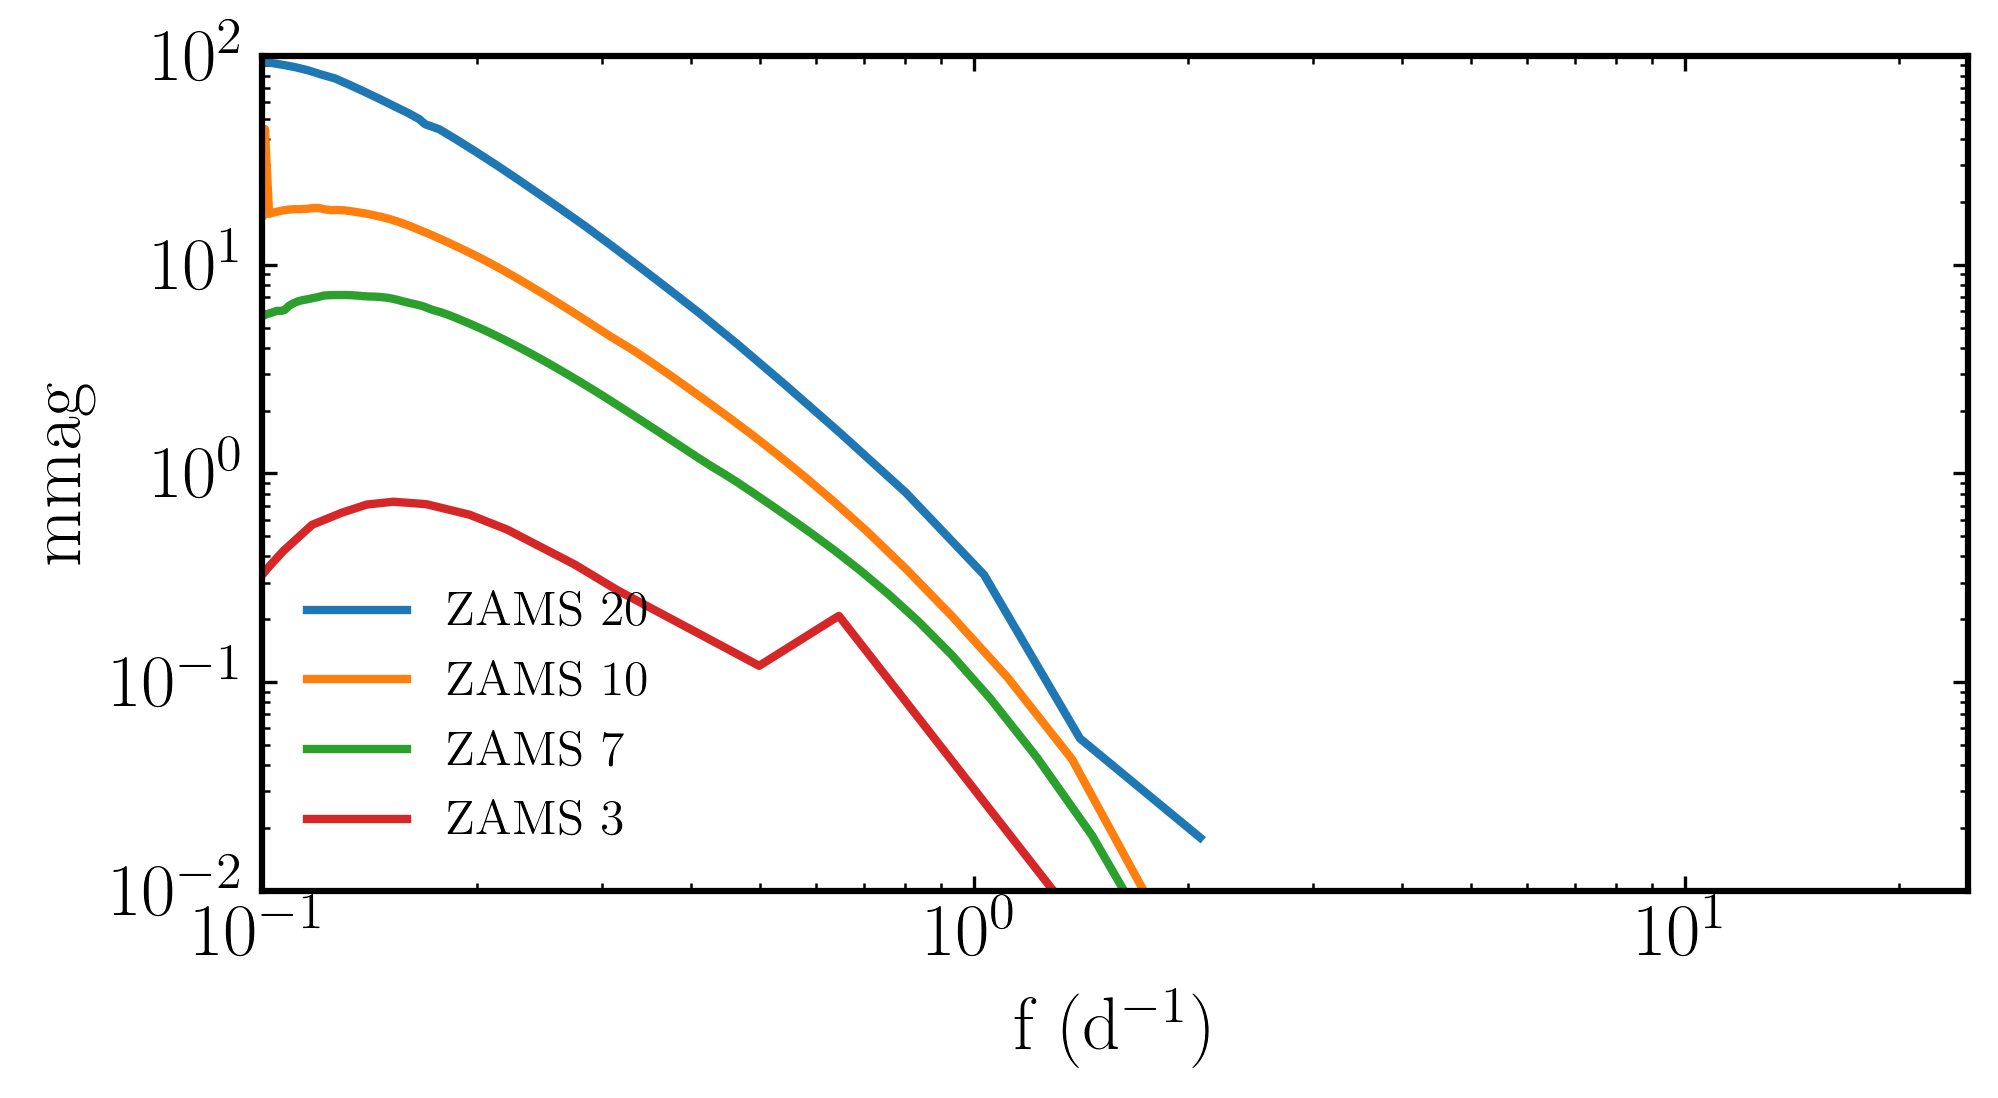

In [47]:
plt.loglog(freq_units*freq_dict['ZAMS_20'],1e3*mode_mag_dict['ZAMS_20'],label='ZAMS 20')
plt.loglog(freq_units*freq_dict['ZAMS_10'],1e3*mode_mag_dict['ZAMS_10'],label='ZAMS 10')
plt.loglog(freq_units*freq_dict['ZAMS_7'],1e3*mode_mag_dict['ZAMS_7'],label='ZAMS 7')
plt.loglog(freq_units*freq_dict['ZAMS_3'],1e3*mode_mag_dict['ZAMS_3'],label='ZAMS 3')
plt.ylabel('mmag')
#plt.xlabel(r'f (Hz)')
plt.xlabel(r'f (d$^{-1}$)')
plt.legend(loc='lower left')
plt.ylim([1e-2,1e2])
plt.xlim([1e-1,25])

## MIDWAY ON THE MAIN SEQUENCE

(0.1, 25)

/Users/mcantiello/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


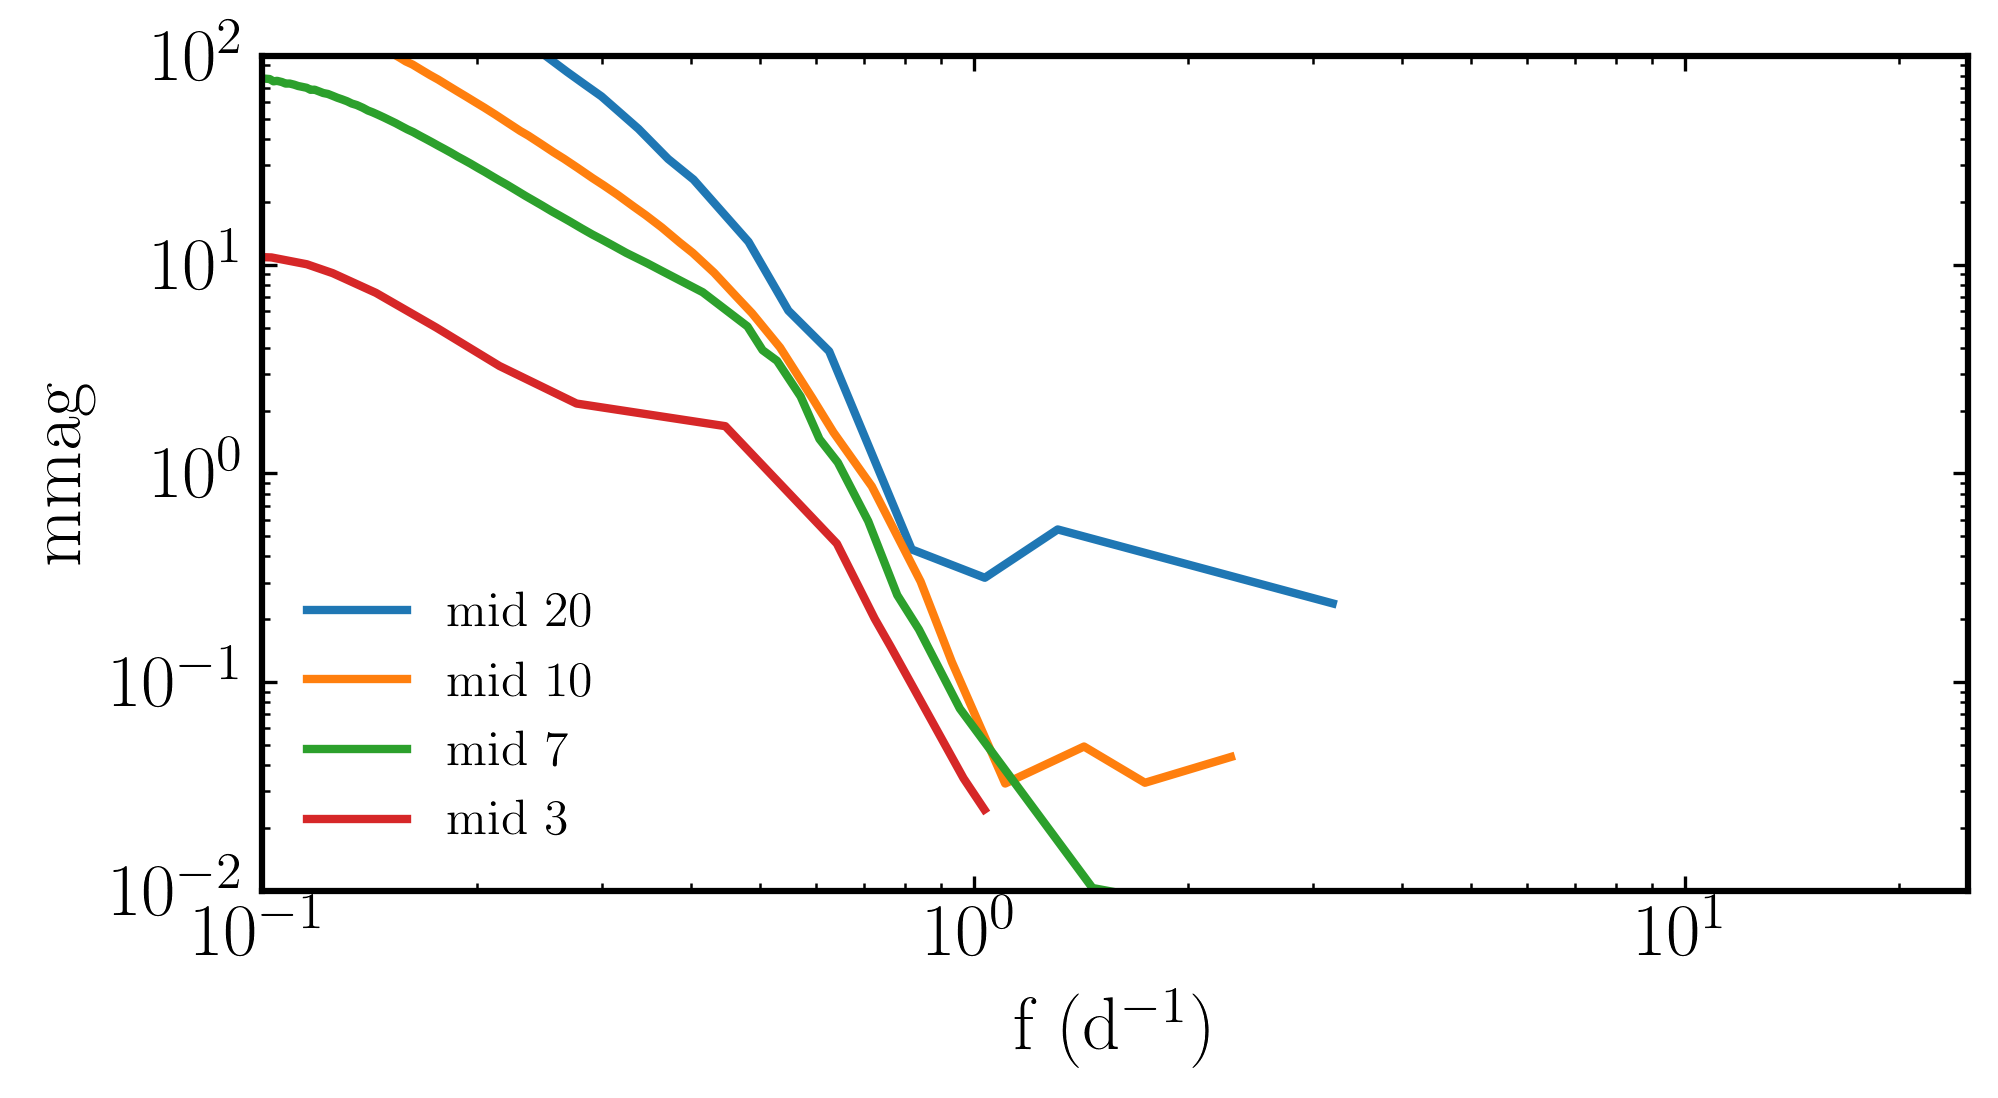

In [48]:
freq_units = 24*60*60
plt.loglog(freq_units*freq_dict['mid_20'],1e3*mode_mag_dict['mid_20'],label='mid 20')
plt.loglog(freq_units*freq_dict['mid_10'],1e3*mode_mag_dict['mid_10'],label='mid 10')
plt.loglog(freq_units*freq_dict['mid_7'],1e3*mode_mag_dict['mid_7'],label='mid 7')
plt.loglog(freq_units*freq_dict['mid_3'],1e3*mode_mag_dict['mid_3'],label='mid 3')
plt.ylabel('mmag')
#plt.xlabel(r'f (Hz)')
plt.xlabel(r'f (d$^{-1}$)')
plt.legend(loc='lower left')
plt.ylim([1e-2,1e2])
plt.xlim([1e-1,25])

## END Of THE MAIN SEQUENCE

(0.1, 25)

/Users/mcantiello/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


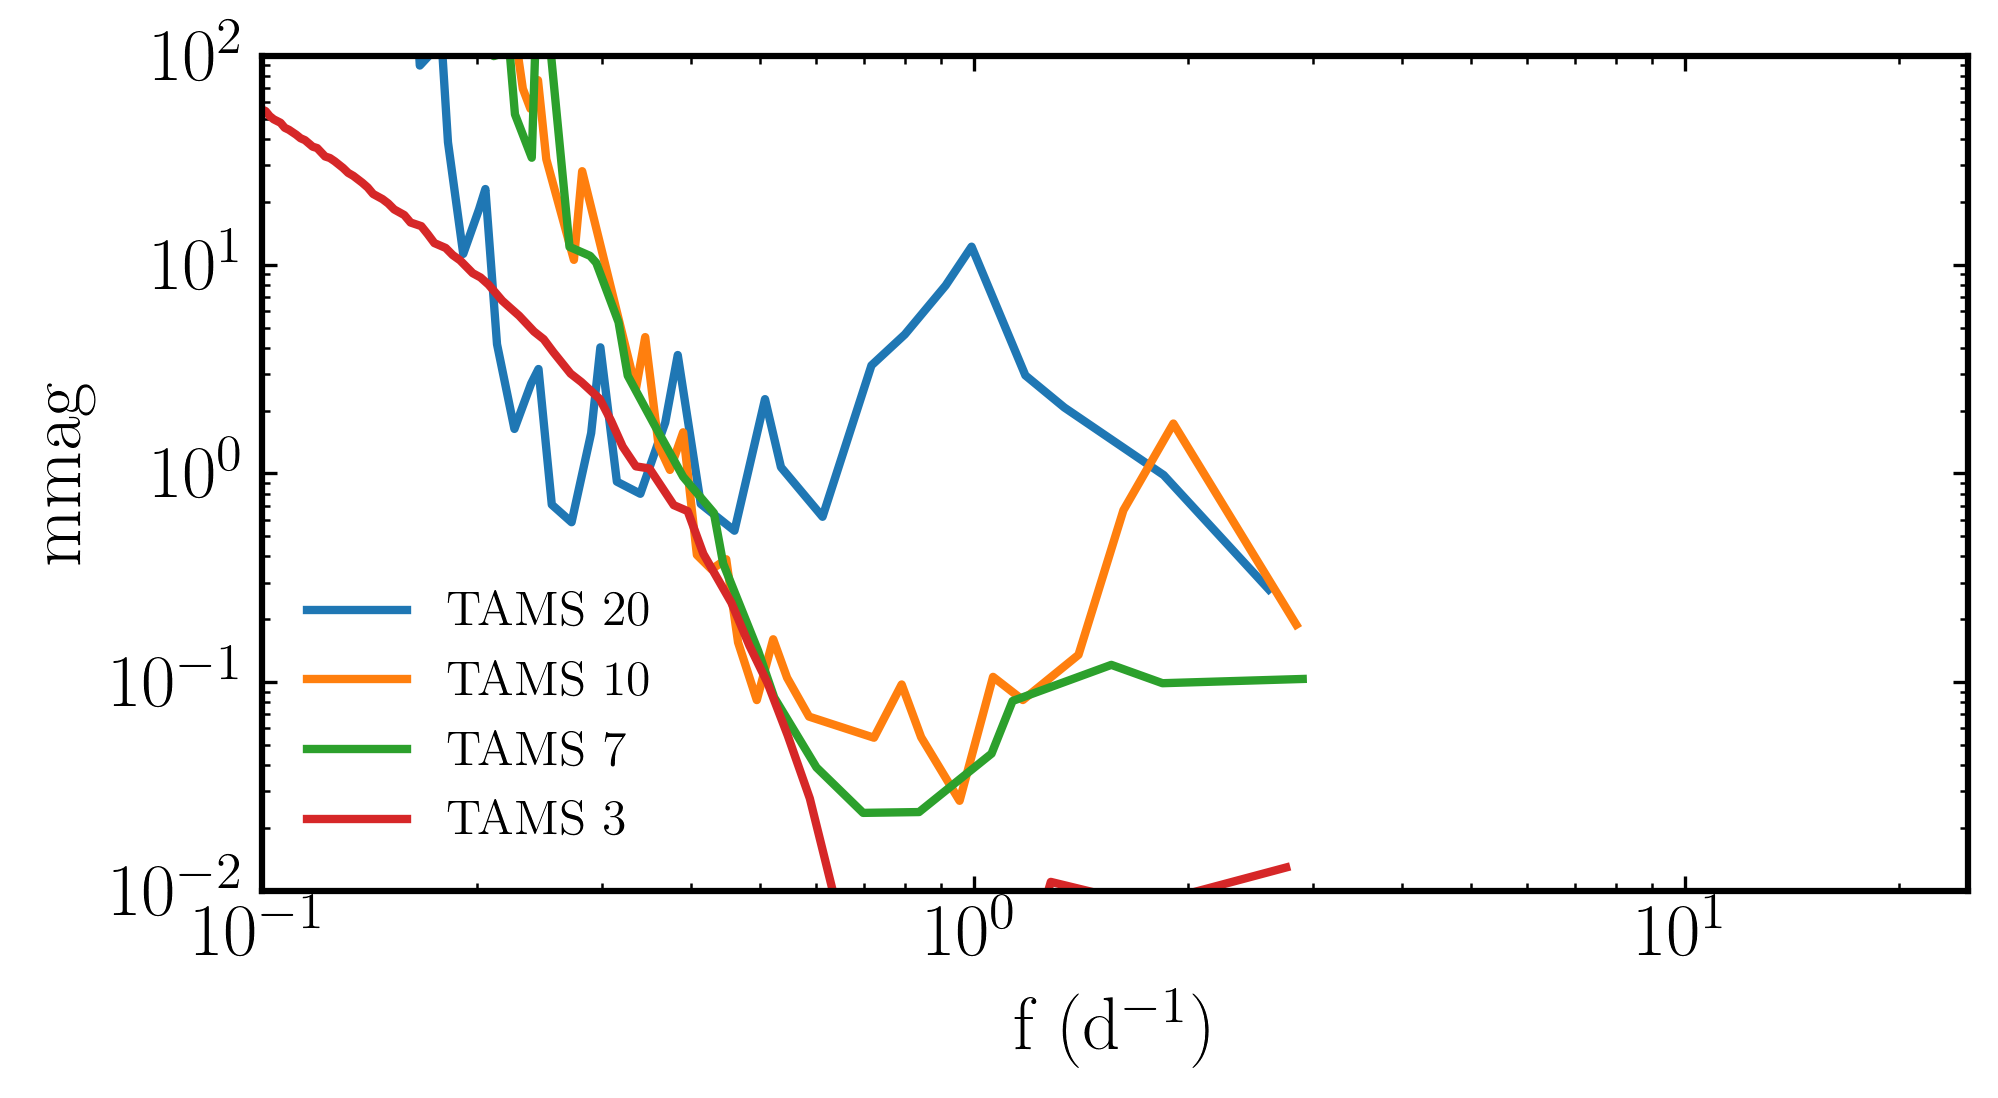

In [49]:
plt.loglog(freq_units*freq_dict['TAMS_20'],1e3*mode_mag_dict['TAMS_20'],label='TAMS 20')
plt.loglog(freq_units*freq_dict['TAMS_10'],1e3*mode_mag_dict['TAMS_10'],label='TAMS 10')
plt.loglog(freq_units*freq_dict['TAMS_7'],1e3*mode_mag_dict['TAMS_7'],label='TAMS 7')
plt.loglog(freq_units*freq_dict['TAMS_3'],1e3*mode_mag_dict['TAMS_3'],label='TAMS 3')
plt.ylabel('mmag')
#plt.xlabel(r'f (Hz)')
plt.xlabel(r'f (d$^{-1}$)')
plt.legend(loc='lower left')
plt.ylim([1e-2,1e2])
plt.xlim([1e-1,25])